# Towards Intrusion Detection for Small Satellites - Python Utilities


**Author:** Nora Silven  
**Date:** --/--/--

This notebook contains all the Python code used during this research. Since the actual Proof-of-Concept is implemented in Java, the Python code here mostly provides helper functionality. 

In [1]:
# All necessary imports.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
from sklearn.datasets import fetch_kddcup99, fetch_covtype, fetch_openml
from sklearn.metrics import auc

## Supervisor Parameter Extraction

The NanoSat MO Supervisor Composite of the NanoSat MO Framework defines many platform-related
parameters. These parameters can be monitored for intrusion detection purposes. Since there are over
10,000 parameters, some keywords are used to find resource-consumption-related supervisor parameters.
These parameters are used as examples of relevant monitoring data, though many other could be relevant
for monitoring as well.

In [2]:
# Load and parse XML file sontaining supervisor parameter names, types, and descriptions.
tree = ET.parse('Datapool.xml')
root = tree.getroot()

params = {}

# Search through the long descriptions of all supervisor parameters.
for pool in root:
    for dict in pool:
        desc = dict.attrib["longDescription"]
        name = dict.attrib["name"]
        
        # Search long descriptions for resource-consumption-related keywords.
        if any(substring in desc for substring in ["SEPP CPU", "SEPP memory", "SEPP disk"]):
            params[name] = desc

# Show names and long descriptions of resource-consumption-related supervisor parameters.
params

{'SEPTM002': 'SEPP memory total',
 'SEPTM003': 'SEPP memory used',
 'SEPTM004': 'SEPP memory free',
 'SEPTM005': 'SEPP memory shared',
 'SEPTM006': 'SEPP memory buffers',
 'SEPTM007': 'SEPP memory cached',
 'SEPTM008': 'SEPP memory used minus buffers/cache',
 'SEPTM009': 'SEPP memory free plus buffers/cache',
 'SEPTM010': 'SEPP CPU use percentage from usr',
 'SEPTM011': 'SEPP CPU use percentage from sys',
 'SEPTM012': 'SEPP CPU use percentage from nic',
 'SEPTM013': 'SEPP CPU use percentage from idle',
 'SEPTM014': 'SEPP CPU use percentage from io',
 'SEPTM015': 'SEPP CPU use percentage from irq',
 'SEPTM016': 'SEPP CPU use percentage from sirq',
 'SEPTM017': 'SEPP disk size',
 'SEPTM018': 'SEPP disk used',
 'SEPTM019': 'SEPP disk available',
 'SEPTM020': 'SEPP disk available perentage'}

## Benchmark Dataset Retrieval

In order to test the performance of the Loda anomaly detection algorithm implemented in Java, labelled benchmark datasets are used. For easy usage in Java, all datasets are formatted to a CSV format. The following benchmark datasets are used:

| Dataset | Samples | Features | Outlier Ratio |
| :- | :-: | :-: | :-: |
| [Shuttle](https://odds.cs.stonybrook.edu/shuttle-dataset/) | 49097 | 9 | 7% |
| [HTTP-3](https://odds.cs.stonybrook.edu/http-kddcup99-dataset/) | 58725 | 3 | 0.4% |
| [Covertype](https://odds.cs.stonybrook.edu/forestcovercovertype-dataset/) | 286048 | 10 | 0.9% |

The Shuttle and Covertype datasets are not binary (i.e. they have more than 2 classes), and so they must be converted to a binary classification problem. This is done as described [here](https://odds.cs.stonybrook.edu/):

- **Shuttle**: For this dataset, observations from class 1 are considered normal, and observation from classes 2, 3, 5, 6, and 7 are considered anomalies. Observations from class 4 are removed.
- **Covertype**: From this dataset, only the 10 quantative features are used. Then, observations from class 2 are considered normal, and observations from class 4 are considered anomalies. Observations from other classes are ignored.

In [3]:
# Load Shuttle dataset, convert it to a binary classification problem, and write to CSV format.
shuttle = fetch_openml("shuttle", parser="auto")
X = shuttle["data"]
y = shuttle["target"]
data = pd.concat([X, y], axis=1)
data = data[data['class'] != '4'].to_numpy()
data[data == '1'] = 0.0
data[np.where(data[:, -1] != 0.0), -1] = 1.0
np.savetxt("shuttle.csv", data, delimiter=',', fmt='%d.0')

# Show Shuttle (StatLog) dataset
df = pd.read_csv("shuttle.csv", header=None)
df.head(5)
df

,0,1,2,3,4,5,6,7,8,9
0,50.0,21.0,77.0,0.0,28.0,0.0,27.0,48.0,22.0,1.0
1,53.0,0.0,82.0,0.0,52.0,-5.0,29.0,30.0,2.0,0.0
2,37.0,0.0,76.0,0.0,28.0,18.0,40.0,48.0,8.0,0.0
3,37.0,0.0,79.0,0.0,34.0,-26.0,43.0,46.0,2.0,0.0
4,85.0,0.0,88.0,-4.0,6.0,1.0,3.0,83.0,80.0,1.0
...,...,...,...,...,...,...,...,...,...,...
49092,39.0,-2.0,80.0,-4.0,38.0,0.0,41.0,41.0,0.0,0.0
49093,43.0,0.0,81.0,1.0,42.0,-9.0,37.0,39.0,2.0,0.0
49094,49.0,0.0,87.0,0.0,46.0,-12.0,38.0,41.0,2.0,0.0
49095,80.0,0.0,84.0,0.0,-36.0,-29.0,4.0,120.0,116.0,1.0


In [4]:
# Load HTTP-3 subset from KDD-CUP-99 dataset and write to CSV format.
http = fetch_kddcup99(subset='http', shuffle=True)
X = http['data']
y = http['target']
y[y == b'normal.'] = 0.0
y[y != 0] = 1.0
np.savetxt("http-3.csv", np.column_stack((X, y)), delimiter=',', fmt='%.16f')

# Show HTTP-3 (KDD-CUP-99) dataset
df = pd.read_csv("http-3.csv", header=None)
df.head(5)
df

,0,1,2,3
0,-2.302585,5.429784,11.821594,0.0
1,-2.302585,5.438514,5.727173,0.0
2,-2.302585,5.533785,5.620763,0.0
3,-2.302585,5.557214,6.013960,0.0
4,-2.302585,5.595083,10.554851,0.0
...,...,...,...,...
58720,-2.302585,5.631570,5.727173,0.0
58721,-2.302585,5.293807,6.951868,0.0
58722,-2.302585,5.759217,8.981694,0.0
58723,-2.302585,5.323498,5.900171,0.0


In [5]:
# Load Covertype dataset, convert it to a binary classification problem, and write to CSV format.
cover = fetch_covtype()
X = cover['data'][:, :10]
y = cover['target']
data = np.column_stack((X, y))
data = data[(data[:, -1] == 2) | (data[:, -1] == 4), :]
data[data[:, -1] == 2, -1] = 0.0
data[data[:, -1] == 4, -1] = 1.0
np.savetxt("cover.csv", data, delimiter=',', fmt='%d.0')

# Show Covertype dataset.
df = pd.read_csv("cover.csv", header=None)
df.head(5)
df

,0,1,2,3,4,5,6,7,8,9,10
0,2804.0,139.0,9.0,268.0,65.0,3180.0,234.0,238.0,135.0,6121.0,0.0
1,2785.0,155.0,18.0,242.0,118.0,3090.0,238.0,238.0,122.0,6211.0,0.0
2,2579.0,132.0,6.0,300.0,-15.0,67.0,230.0,237.0,140.0,6031.0,0.0
3,2886.0,151.0,11.0,371.0,26.0,5253.0,234.0,240.0,136.0,4051.0,0.0
4,2742.0,134.0,22.0,150.0,69.0,3215.0,248.0,224.0,92.0,6091.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
286043,2617.0,29.0,13.0,390.0,128.0,2081.0,215.0,211.0,130.0,592.0,0.0
286044,2614.0,21.0,13.0,379.0,125.0,2051.0,211.0,212.0,135.0,618.0,0.0
286045,2612.0,17.0,13.0,371.0,123.0,2021.0,208.0,211.0,138.0,644.0,0.0
286046,2610.0,16.0,14.0,365.0,110.0,1991.0,208.0,211.0,138.0,671.0,0.0


## ROC Curve Generation

A representation of anomaly detection performance often used is the ROC Curve. This curve plots
the recall (true positive rate) against the false alarm rate (false positive rate), for different anomaly
threshold values. The Area Under the Curve (AUC) is generally used as a performance metric for
anomaly detection algorithms. The Loda implementation in Java is executed with the three different
datasets with 9 different anomaly percentage values, each resulting in different anomaly thresholds.
For each dataset and anomaly threshold, the average recall and false-positive rate is taken from 100
executions. Furthermore, the average execution time is calculated for each dataset. The same is done
with the IDS implemented as part of the NanoSat MO Framework, where teh recall and false-positive
rate of 5 executions, each of 4 hours, are averaged, for multiple anomaly percentage values.

Mean Execution Time: 2199.0255555555555 ms


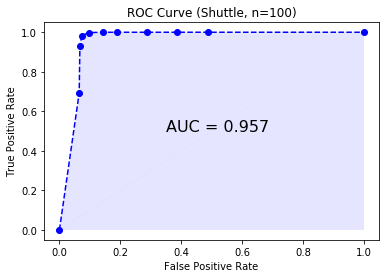

In [6]:
# Process ROC Curve points for Shuttle dataset.
roc_points = [[0.0, 0.0], [0.06499846444083707, 0.6933722586157791], 
              [0.06729785460448384, 0.9326060951295926], 
              [0.07337515904005619, 0.9825519794930218], 
              [0.0959079541964638, 0.9982739960125327], 
              [0.14169043127275915, 0.9997977784107093], 
              [0.1903165445531522, 0.9998718313870691], 
              [0.286553766507261, 0.999994303617203], 
              [0.38622888606151, 1.0], [0.4891203439652525, 1.0], [1.0, 1.0]]
fpr = np.array(roc_points)[:, 0]
recall = np.array(roc_points)[:, 1]
avg_dur = [2200.62, 2197.43, 2214.44, 2198.38, 2176.9, 2200.64, 2223.61, 
           2189.24, 2189.97]
print("Mean Execution Time: " + str(np.mean(avg_dur)) + " ms")

# Calculate AUC for Shuttle dataset.
auc_str = "AUC = " + "{:.3f}".format(auc(fpr, recall))

# Plot ROC Curve for Shuttle dataset.
plt.plot(fpr, recall, '--bo')
plt.fill(fpr, recall, [0.0, 1.0, 1.0], [0.0, 0.0, 1.0], facecolor='blue', alpha=0.1)
plt.text(0.35, 0.5, auc_str, fontsize=16)
plt.title("ROC Curve (Shuttle, n=100)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

Mean Execution Time: 3100.2000000000003 ms


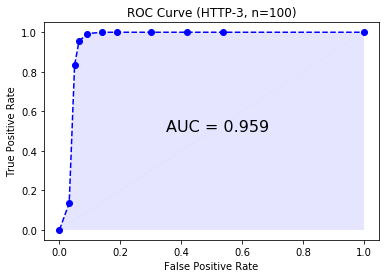

In [7]:
# Process ROC Curve points for HTTP-3 dataset.
roc_points = [[0.0, 0.0], [0.032091089249062225, 0.13523766410140334], 
              [0.04984323023568546, 0.8332231779085558], 
              [0.0641977493099299, 0.9538660027161615], 
              [0.09137607049331166, 0.9934314169307392], 
              [0.13971884068228474, 0.9996740606609328], 
              [0.18863649232075866, 1.0], [0.3019017623327907, 1.0], 
              [0.4185977422322884, 1.0], [0.5360161724113521, 1.0], [1.0, 1.0]]
fpr = np.array(roc_points)[:, 0]
recall = np.array(roc_points)[:, 1]
avg_dur = [2914.57, 3182.58, 3252.97, 3149.33, 3106.96, 3070.08, 3053.38, 
           3030.6, 3141.33]
print("Mean Execution Time: " + str(np.mean(avg_dur)) + " ms")

# Calculate AUC for HTTP-3 dataset.
auc_str = "AUC = " + "{:.3f}".format(auc(fpr, recall))

# Plot ROC Curve for HTTP-3 dataset.
plt.plot(fpr, recall, '--bo')
plt.fill(fpr, recall, [0.0, 1.0, 1.0], [0.0, 0.0, 1.0], facecolor='blue', alpha=0.1)
plt.text(0.35, 0.5, auc_str, fontsize=16)
plt.title("ROC Curve (HTTP-3, n=100)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

Mean Execution Time: 11216.95888888889 ms


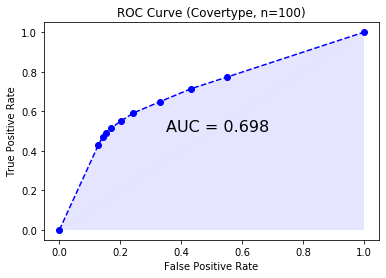

In [8]:
# Process ROC Curve points for Covertype dataset.
roc_points = [[0.0, 0.0], [0.12798034599242503, 0.4300182016745539], 
              [0.142818698133787, 0.4714852566436113], 
              [0.1535040116342688, 0.4885839097196941], 
              [0.17034334506408375, 0.5162286130323991], 
              [0.20395999308156354, 0.5528030578813248], 
              [0.2427658215113958, 0.5912085911903893], 
              [0.3300157782711674, 0.6486567164179103], 
              [0.4325462670445922, 0.7142409901710957], 
              [0.5509161633739379, 0.7734801601747356], [1.0, 1.0]]
fpr = np.array(roc_points)[:, 0]
recall = np.array(roc_points)[:, 1]
avg_dur = [11285.84, 11196.09, 11184.34, 11127.02, 11149.05, 11209.31, 11265.94, 
           11304.83, 11230.21]
print("Mean Execution Time: " + str(np.mean(avg_dur)) + " ms")

# Calculate AUC for Covertype dataset.
auc_str = "AUC = " + "{:.3f}".format(auc(fpr, recall))

# Plot ROC Curve for Covertype dataset.
plt.plot(fpr, recall, '--bo')
plt.fill(fpr, recall, [0.0, 1.0, 1.0], [0.0, 0.0, 1.0], facecolor='blue', alpha=0.1)
plt.text(0.35, 0.5, auc_str, fontsize=16)
plt.title("ROC Curve (Covertype, n=100)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

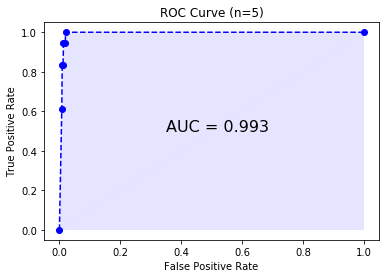

In [9]:
# Process ROC Curve points for the proposed IDS.
roc_points = [[0.0, 0.0], [0.007735583684950774, 0.6111111111111112],
              [0.009142053445850914, 0.8333333333333334], 
              [0.011971830985915493, 0.8333333333333334], 
              [0.013361462728551337, 0.9444444444444444], 
              [0.0189873417721519, 0.9444444444444444], 
              [0.020438818565400843, 1.0], [1.0, 1.0]]
fpr = np.array(roc_points)[:, 0]
recall = np.array(roc_points)[:, 1]

# Calculate AUC for the proposed IDS.
auc_str = "AUC = " + "{:.3f}".format(auc(fpr, recall))

# Plot ROC Curve for the proposed IDS.
plt.plot(fpr, recall, '--bo')
plt.fill(fpr, recall, [0.0, 1.0, 1.0], [0.0, 0.0, 1.0], facecolor='blue', alpha=0.1)
plt.text(0.35, 0.5, auc_str, fontsize=16)
plt.title("ROC Curve (n=5)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()